In [243]:
import pandas as pd
import numpy as np

import os
import random 

In [3]:
 file_list = [col for col in os.listdir('F:/南大实习') if 'df_res' in col ]

In [5]:
df_train = pd.read_csv('F:/南大实习/'+file_list[0])

In [6]:
df_train.shape

(1312182, 29)

In [7]:
df_train.head()

tradingday  secucode  annualized_traded_value_ratio  \
0    20210104    600000                       0.177095   
1    20210104    600004                       0.938421   
2    20210104    600006                       3.601800   
3    20210104    600007                       0.251752   
4    20210104    600008                       0.572542   

   average_turnoverrate_1m  average_turnoverrate_1q  average_turnoverrate_1yr  \
0                -3.485384                -3.196405                 -3.418906   
1                -2.162102                -1.723062                 -1.614041   
2                 0.540058                 0.081271                 -0.822145   
3                -3.513784                -3.240397                 -2.867258   
4                -2.338368                -2.248811                 -2.144780   

   daily_std_dec  hist_sigma  historical_alpha   beta_1y  ...  \
0       0.011217    0.009225         -0.001427  0.657311  ...   
1       0.020497    0.020530         -0.001513  0.785064  ...   
2       0.040336    0.028065          0.005639  0.738977  ...   
3       0.014859    0.014606         -0.002015  0.734948  ...   
4       0.011124    0.012000         -0.001372  0.552089  ...   

   turn_val_std_mean_6m   std_12m    std_3m    std_6m  holding_return_1m  \
0              0.455910  1.391080  1.010629  1.081610          -1.055209   
1              0.642062  2.485429  1.978049  1.955248          -1.073446   
2              1.344840  3.101549  4.549812  3.558259          -0.625504   
3              0.690019  1.872656  1.211226  1.583762          -1.048792   
4              0.553942  1.566930  0.856861  1.309984          -1.064322   

   relative_strength  long_term_relative_strength  long_term_historical_alpha  \
0          -3.802548                    -2.902941                         NaN   
1          -3.020786                    -7.889663                 -457.130291   
2          23.500513                     4.564931                         NaN   
3          -6.973244                    -3.326502                 -131.854588   
4          -1.026197                     6.456878                         NaN   

   short_term_revarsal  dr_abs_val_mean_log_20d  
0             3.203864                -4.250377  
1            19.627084                -2.523571  
2           105.295670                -2.832770  
3            -9.081989                -0.656950  
4            -2.477899                -2.679367  

[5 rows x 29 columns]

In [24]:
df_train.dtypes
df_train.isnull().sum()
isnull_dict = dict(df_train.isnull().sum()/df_train.shape[0])
feature_columns = [col for col in isnull_dict.keys() if isnull_dict[col]<=0.1 and col not in ['tradingday','secucode']]

len(feature_columns)

26

In [10]:
df_train['tradingday'] = df_train['tradingday'].astype(str)
df_train['secucode'] = df_train['secucode'].apply(lambda x:str(x).zfill(6))

异常值截断:  
1.3sigma;  
2.分为点数：[2.5,97.5];  
3.中位数绝对偏差（MAD）；  

In [25]:
df_train = df_train.sort_values(['secucode'])

In [13]:
def Filterby3Sigma(x):
    x_ = np.array(x)
    std_ = np.nanstd(x_)
    mean_= np.nanmean(x_)
    low_ = mean_ - 3*std_
    up_ = mean_ + 3*std_
    x_[x_<low_] = low_
    x_[x_>up_] = up_
    return x_

In [30]:
c = feature_columns[0]
df_train[c+'_f1'] = df_train.groupby(['secucode'])[c].transform(Filterby3Sigma)

In [34]:
"""check ===^-^"""
secucode_ = random.sample(list(df_train['secucode'].unique()),1)[0]
set(Filterby3Sigma(df_train[df_train['secucode']==secucode_][c]) - df_train[df_train['secucode']==secucode_][c+'_f1'].values)

In [46]:
"""检查正确之后，开始循环每个特征!一定要检查~~~"""
# for c in feature_columns:
#     df_train[c+'_f1'] = df_train.groupby(['secucode'])[c].transform(Filterby3Sigma)

In [47]:
def FilterbyPercentile(x):
    x_ = np.array(x)
    low_ = np.nanpercentile(x_,2.5)
    up_ = np.nanpercentile(x_,97.5)
    x_[x_<low_] = low_
    x_[x_>up_] = up_
    return x_

In [49]:
df_train[c+'_f2'] = df_train.groupby(['secucode'])[c].transform(FilterbyPercentile)
set(FilterbyPercentile(df_train[df_train['secucode']==secucode_][c]) - df_train[df_train['secucode']==secucode_][c+'_f2'].values)

{0.0}

In [50]:
#  for c in feature_columns:
#     df_train[c+'_f2'] = df_train.groupby(['secucode'])[c].transform(FilterbyPercentile)

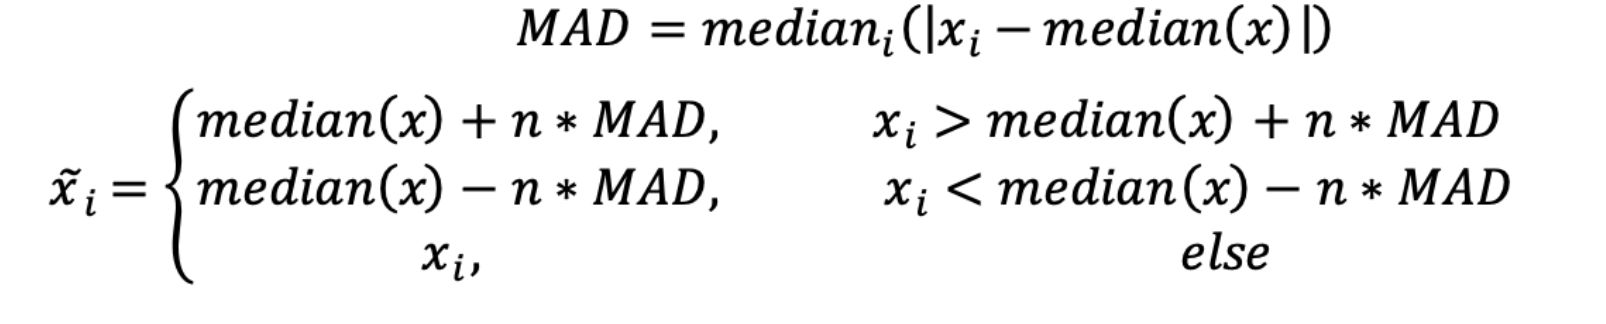

In [59]:
def FilterbyMAD(x,N= 3):
    x_ = np.array(x)
    median_ = np.nanpercentile(x_,50)
    mad_= np.nanpercentile(abs(x_ - median_),50)
    low_ = median_ - N*mad_
    up_ = median_ + N*mad_
    x_[x_<low_] = low_
    x_[x_>up_] = up_
    return x_

In [60]:
df_train[c+'_f3'] = df_train.groupby(['secucode'])[c].transform(FilterbyMAD)
set(FilterbyMAD(df_train[df_train['secucode']==secucode_][c]) - df_train[df_train['secucode']==secucode_][c+'_f3'].values)

{0.0}

缺失值填充：  
1.均值；  
2.中位数；  
3.众数；  
5.前一日；  


In [69]:
# fill_cols = [c for c in feature_columns if isnull_dict[c]>0]
c = fill_cols[0]

In [71]:
df_train[pd.isnull(df_train[c])][['tradingday','secucode',c]]

tradingday secucode  turn_val_std_mean_12m
622866   20210810   000792                    NaN
319596   20210428   001201                    NaN
323840   20210429   001202                    NaN
340843   20210510   001203                    NaN
353649   20210513   001205                    NaN
...           ...      ...                    ...
543448   20210715   688793                    NaN
640254   20210816   688798                    NaN
534707   20210713   688799                    NaN
565334   20210722   688800                    NaN
42943    20210118   688819                    NaN

[558 rows x 3 columns]

In [76]:
df_train[c].fillna(df_train['secucode'].map(df_train.groupby(['secucode'])[c].mean().to_dict()),inplace = True)

In [77]:
'''检查是否填充正确'''
df_train[(df_train['secucode']=='000792')&(df_train['tradingday']=='20210810')][['tradingday','secucode',c]]

tradingday secucode  turn_val_std_mean_12m
622866   20210810   000792               0.805385

In [75]:
df_train.groupby(['secucode'])[c].mean().to_dict()['000792']

0.8053846335751363

In [79]:
for c in fill_cols:
    df_train[c].fillna(df_train['secucode'].map(df_train.groupby(['secucode'])[c].mean().to_dict()),inplace = True)

In [134]:
'''中位数'''
# df_train[c].fillna(df_train['secucode'].map(df_train.groupby(['secucode'])[c].median().to_dict()),inplace = True)
'''众数:mode 可能返回多个值，所以再要做以此聚合操作'''
df_train.groupby(['secucode'])[c].apply(lambda x:x.mode())

secucode     
000001    0      0.404903
          1      0.404992
          2      0.405028
          3      0.405250
          4      0.405513
                   ...   
688981    293    1.414533
          294    1.414551
          295    1.415320
          296    1.416855
          297    1.418824
Name: turn_val_std_mean_12m, Length: 1312179, dtype: float64

In [140]:
""""""
c = fill_cols[1]
df_train[pd.isnull(df_train[c])]

tradingday secucode  annualized_traded_value_ratio  \
622866   20210810   000792                       0.168818   
319596   20210428   001201                       0.029340   
323840   20210429   001202                       0.013022   
340843   20210510   001203                       0.012561   
353649   20210513   001205                       0.012169   
...           ...      ...                            ...   
543448   20210715   688793                       0.900366   
640254   20210816   688798                       0.829495   
534707   20210713   688799                       0.884857   
565334   20210722   688800                       0.919015   
42943    20210118   688819                       0.785946   

        average_turnoverrate_1m  average_turnoverrate_1q  \
622866                -1.933500                -3.032113   
319596                -3.683375                -4.781987   
323840                -4.495688                -5.594300   
340843                -4.531734                -5.630346   
353649                -4.563453                -5.662065   
...                         ...                      ...   
543448                -0.259518                -1.358131   
640254                -0.341503                -1.440116   
534707                -0.276894                -1.375506   
565334                -0.239018                -1.337630   
42943                 -0.395432                -1.494044   

        average_turnoverrate_1yr  daily_std_dec    hist_sigma  \
622866                 -4.418407   4.440892e-16  0.000000e+00   
319596                 -6.168281   0.000000e+00  6.052756e-18   
323840                 -6.980595   1.110223e-16  0.000000e+00   
340843                 -7.016641   5.551115e-17  2.657303e-17   
353649                 -7.048359   5.551115e-17  1.259083e-17   
...                          ...            ...           ...   
543448                 -2.744425   8.881784e-16  5.583886e-17   
640254                 -2.826410   4.440892e-16  0.000000e+00   
534707                 -2.761800   0.000000e+00  0.000000e+00   
565334                 -2.723924   8.881784e-16  3.955633e-16   
42943                  -2.880339   0.000000e+00  3.489929e-18   

        historical_alpha       beta_1y  ...  holding_return_1m  \
622866          3.061086  0.000000e+00  ...           0.401450   
319596          0.440044  3.885781e-16  ...          -0.635326   
323840          0.440027  6.661338e-16  ...          -0.635338   
340843          0.439866 -6.661338e-16  ...          -0.635450   
353649          0.440073  1.110223e-15  ...          -0.635306   
...                  ...           ...  ...                ...   
543448          5.247445  1.243450e-14  ...           0.832173   
640254          2.405589  0.000000e+00  ...           0.225418   
534707          0.752109  3.330669e-15  ...          -0.439180   
565334          5.358189  8.881784e-15  ...           0.849744   
42943           0.471165 -1.110223e-16  ...          -0.613945   

        relative_strength  long_term_relative_strength  \
622866                0.0                     0.814273   
319596                0.0                     0.000000   
323840                0.0                     0.000000   
340843                0.0                     0.000000   
353649                0.0                     0.000000   
...                   ...                          ...   
543448                0.0                     0.000000   
640254                0.0                     0.000000   
534707                0.0                     0.000000   
565334                0.0                     0.000000   
42943                 0.0                     0.000000   

        long_term_historical_alpha  short_term_revarsal  \
622866                         NaN          4190.564740   
319596                         NaN           602.411324   
323840                         NaN           602.388051   
340843                         NaN           6

In [152]:
df_train[(df_train['secucode']=='001202')&(df_train['tradingday']<='20210429')][['tradingday','secucode',c]].sort_values('tradingday')

tradingday secucode  turn_val_std_mean_1m
323840   20210429   001202                   NaN

In [210]:
def FillPad(x):
    x = x.values
    for i in np.where(np.isnan(x))[0]:
        x[i] = x[i-1] if i>0 else np.nan
    return x

In [213]:
df_train = df_train.sort_values(['secucode','tradingday'])
# df_train[c+'_p'] = df_train.groupby(['secucode'])[c].transform(FillPad)
df_train[c+'_p'] = df_train.groupby(['secucode'])[c].apply(lambda x:x.fillna(method='pad'))

In [217]:
df_train[(df_train['secucode']=='001202')&(df_train['tradingday']>='20210429')][['tradingday','secucode',c+'_p']].sort_values('tradingday')

tradingday secucode  turn_val_std_mean_1m_p
323840    20210429   001202                     NaN
328065    20210430   001202                0.420317
332323    20210506   001202                0.309388
336582    20210507   001202                0.310123
340842    20210510   001202                0.270400
...            ...      ...                     ...
1291361   20220322   001202                0.967025
1296027   20220323   001202                0.949114
1300693   20220324   001202                0.910995
1305358   20220325   001202                0.888679
1310027   20220328   001202                0.875105

[221 rows x 3 columns]

归一化：  
最大最小值归一化；  
Zscore;  

In [218]:
def MinMaxScale(x):
    x = np.array(x)
    min_ = np.nanmin(x)
    max_ = np.nanmax(x)
    return (x-min_)/(max_ - min_) if max_ != min_ else x

In [219]:
c = feature_columns[0]

In [226]:
df_train[c+'_ms'] = df_train.groupby(['secucode'])[c].transform(MinMaxScale)
set(MinMaxScale(df_train[df_train['secucode']==secucode_][c]) - df_train[df_train['secucode']==secucode_][c+'_ms'].values)

{0.0}

In [228]:
def ZScoreScale(x):
    x = np.array(x)
    mean_ = np.nanmean(x)
    std_ = np.nanmax(x)
    return (x-mean_)/(std_) if std_!=0 else x

df_train[c+'_zs'] = df_train.groupby(['secucode'])[c].transform(ZScoreScale)
set(ZScoreScale(df_train[df_train['secucode']==secucode_][c]) - df_train[df_train['secucode']==secucode_][c+'_zs'].values)

{0.0}

In [230]:
"""特征选择"""
df_corr = df_train[feature_columns].corr()

In [233]:
df_corr.head()

annualized_traded_value_ratio  \
annualized_traded_value_ratio                       1.000000   
average_turnoverrate_1m                             0.767423   
average_turnoverrate_1q                             0.842112   
average_turnoverrate_1yr                            0.790883   
daily_std_dec                                       0.388162   

                               average_turnoverrate_1m  \
annualized_traded_value_ratio                 0.767423   
average_turnoverrate_1m                       1.000000   
average_turnoverrate_1q                       0.923822   
average_turnoverrate_1yr                      0.716869   
daily_std_dec                                 0.392538   

                               average_turnoverrate_1q  \
annualized_traded_value_ratio                 0.842112   
average_turnoverrate_1m                       0.923822   
average_turnoverrate_1q                       1.000000   
average_turnoverrate_1yr                      0.815322   
daily_std_dec                                 0.388654   

                               average_turnoverrate_1yr  daily_std_dec  \
annualized_traded_value_ratio                  0.790883       0.388162   
average_turnoverrate_1m                        0.716869       0.392538   
average_turnoverrate_1q                        0.815322       0.388654   
average_turnoverrate_1yr                       1.000000       0.219478   
daily_std_dec                                  0.219478       1.000000   

                               hist_sigma  historical_alpha   beta_1y  \
annualized_traded_value_ratio    0.454805          0.035113  0.063013   
average_turnoverrate_1m          0.354841          0.095075  0.042727   
average_turnoverrate_1q          0.379725          0.050477  0.074958   
average_turnoverrate_1yr         0.321257         -0.042184  0.149019   
daily_std_dec                    0.865838          0.317002  0.055231   

                               decl_dr_wgt_mean_6_month  \
annualized_traded_value_ratio                  0.098602   
average_turnoverrate_1m                        0.171231   
average_turnoverrate_1q                        0.135268   
average_turnoverrate_1yr                      -0.010944   
daily_std_dec                                  0.640975   

                               decl_dr_wgt_mean_12_month  ...  \
annualized_traded_value_ratio                   0.137933  ...   
average_turnoverrate_1m                         0.186881  ...   
average_turnoverrate_1q                         0.156716  ...   
average_turnoverrate_1yr                        0.031952  ...   
daily_std_dec                                   0.693811  ...   

                               turn_val_std_mean_3m  turn_val_std_mean_6m  \
annualized_traded_value_ratio              0.079149              0.137642   
average_turnoverrate_1m                    0.246304              0.255902   
average_turnoverrate_1q                    0.191208              0.230981   
average_turnoverrate_1yr                   0.019025              0.069753   
daily_std_dec                              0.060674              0.087932   

                                std_12m    std_3m    std_6m  \
annualized_traded_value_ratio  0.285986  0.141961  0.216948   
average_turnoverrate_1m        0.295106  0.248658  0.272845   
average_turnoverrate_1q        0.272107  0.200392  0.244002   
average_turnoverrate_1yr       0.135603  0.032969  0.073893   
daily_std_dec                  0.911176  0.723569  0.860655   

                               holding_return_1m  relative_strength  \
annualized_traded_value_ratio           0.001773           0.421023   
average_turnoverrate_1m                 0.201516           0.420405   
average_turnoverrate_1q                 0.037868           0.431823   
average_turnoverrate_1yr               -0.060818           0.216622   
daily_std_dec                           0.201217           0.474086   

                               long_term_relative

In [240]:
df_corr.columns
select_col = []
for i in range(len(feature_columns)):
    select_col.append(feature_columns[i])
    for j in range(i+1,len(feature_columns)):
        if df_corr.loc[feature_columns[i],feature_columns[j]]<0.8:
            select_col.append(feature_columns[j])
            i = j+1

In [241]:
len(set(select_col))

26